# Model Training

## Dataset and DataLoader

The Dataset and DataLoader classes encapsulate the process of pulling your data from storage and exposing it to your training loop in batches.

The Dataset is responsible for accessing and processing single instances of data.

The DataLoader pulls instances of data from the Dataset (either automatically or with a sampler that you define), collects them in batches, and returns them for consumption by your training loop. The DataLoader works with all kinds of datasets, regardless of the type of data they contain.

We use torchvision.transforms.Normalize() to zero-center and normalize the distribution of the image tile content, and download both training and validation data splits.



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Shirt Bag Shirt Coat


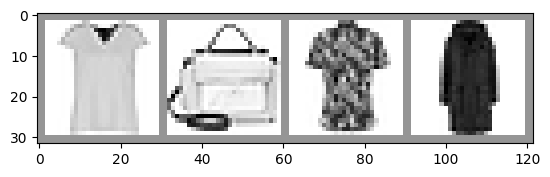

In [3]:
# Visualizing the data
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img/2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))
    
dataiter = iter(training_loader)
images, labels = next(dataiter)

# create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print(' '.join(classes[labels[j]] for j in range(4)))

## The Model

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# Pytorch models inherit from torch.nn.Module
class GarmentClassifer(nn.Module):
    def __init__(self):
        super(GarmentClassifer, self).__init__()
        self.conv1 = nn.Conv2d(1,6,3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = GarmentClassifer()

## Loss Function

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect the data in batches, so we are creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4,10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1,5,3,7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total Loss for this batch: {}'.format(loss.item()))

tensor([[0.3556, 0.9192, 0.7689, 0.9131, 0.2164, 0.2947, 0.2788, 0.5346, 0.4920,
         0.3872],
        [0.0855, 0.9061, 0.9003, 0.2267, 0.8943, 0.4355, 0.7913, 0.9441, 0.8491,
         0.5884],
        [0.2734, 0.5215, 0.5082, 0.2961, 0.8016, 0.9316, 0.4068, 0.1876, 0.1776,
         0.0364],
        [0.0199, 0.6402, 0.3897, 0.2563, 0.4374, 0.7078, 0.4785, 0.4819, 0.7710,
         0.9050]])
tensor([1, 5, 3, 7])
Total Loss for this batch: 2.329662322998047


## Optimizer

- Learning rate determines the size of the steps the optimizer takes
- Momentum nudges the optimizer in the direction of the strongest gradient over multiple steps.
- Try some different optimization algorithms such as averaged SGD, Adagrad, Adam


In [13]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## The Training Loop

 It enumerates data from the DataLoader, and on each pass of the loop does the following:

- Gets a batch of training data from the DataLoader

- Zeros the optimizer’s gradients

- Performs an inference - that is, gets predictions from the model for an input batch

- Calculates the loss for that set of predictions vs. the labels on the dataset

- Calculates the backward gradients over the learning weights

- Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose

- It reports on the loss for every 1000 batches.

- Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run

In [16]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0
    last_loss = 0

    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)

        # compute the loss and it's gradient
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        running_loss += loss.item()
        if i%1000 == 999:
            last_loss = running_loss / 1000     # loss per batch
            print(' batch {} loss: {}'.format(i+1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
        
    return last_loss

## Per-Epoch Activity

- perform validation by checking our relative loss on a set of data that was not used for training and report this

- save a copy of the model

In [18]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000

for epoch in range(EPOCHS):
    print("EPOCH {}:".format(epoch_number+1))
    # Make sure gradient tracking is on and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and 
    # using population statistics for batch normalization
    model.eval()

    # Disabling gradient computation and reduce memory consumption
    with torch.no_grad():
        for i,vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss/(i+1)
    print('Loss train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss average per batch for training and validation
    writer.add_scalars('Training vs Validation Loss', {'training': avg_loss, 'validation': avg_vloss}, epoch_number+1)
    writer.flush()

    # Track best performance and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    epoch_number += 1

EPOCH 1:
 batch 1000 loss: 0.4162347732186172
 batch 2000 loss: 0.396567293529748
 batch 3000 loss: 0.38364572353917176
 batch 4000 loss: 0.3821971240330604
 batch 5000 loss: 0.4049240105479257
 batch 6000 loss: 0.37119219710919427
 batch 7000 loss: 0.3655538364317326
 batch 8000 loss: 0.36531807727081467
 batch 9000 loss: 0.3554329101992407
 batch 10000 loss: 0.36840275773998293
 batch 11000 loss: 0.385828946279129
 batch 12000 loss: 0.37769150818089836
 batch 13000 loss: 0.3770883364690235
 batch 14000 loss: 0.35604417402122635
 batch 15000 loss: 0.35870866993500383
Loss train 0.35870866993500383 valid 0.3817995488643646
EPOCH 2:
 batch 1000 loss: 0.34877264730090973
 batch 2000 loss: 0.3457287328160601
 batch 3000 loss: 0.33760132688374145
 batch 4000 loss: 0.33484094184680724
 batch 5000 loss: 0.3353572844403243
 batch 6000 loss: 0.3454665229913662
 batch 7000 loss: 0.33355055543732304
 batch 8000 loss: 0.3310701325015543
 batch 9000 loss: 0.3336000036658006
 batch 10000 loss: 0.32